In [ ]:
using Pkg; Pkg.activate("C:\\Users\\KarlH\\Desktop\\ComputationalPhysicsMaster\\Code\\OrbitalNeuralMethods")
using Revise
using OrbitalNeuralMethods

In [ ]:
using PyFormattedStrings
import Plots as plt

In [ ]:
l = 10
ω = 0.25
basis = SpinBasis(HOBasis(l, ω))

n = 2
V = ShieldedCoulomb(0.25)
grid = [x for x in range(-10, stop = 10, length = 2001)]
system = System(n, basis, grid, V);

## Convergence setup

In [10]:
function how_fast(state; max_iter, tol)
    iters = 1
    old_E = energy(state)

    for i in 1:max_iter
        update!(state)

        new_E = energy(state)
        if abs(new_E - old_E) < tol
            return iters
        end
        old_E = new_E
        iters += 1
    end
    return max_iter
end

how_fast (generic function with 1 method)

## Convergence Acceleration

In [14]:
ccsd = setup_CCSD(System(rhf));
println(how_fast(ccsd, max_iter=100, tol=1e-10))
ccd = setup_CCD(System(rhf));
println(how_fast(ccd, max_iter=100, tol=1e-10))

17
15


In [22]:
alphas = 0:0.01:1
max_iter = 300

needed_iters_ccd = zero(alphas)
needed_iters_ccsd = zero(alphas)

for (i, alpha) in enumerate(alphas)
    ccd = setup_CCD(System(rhf), Alpha(alpha))
    needed_iters_ccd[i] = how_fast(ccd, max_iter = max_iter, tol = 1e-10)
    
    ccsd = setup_CCSD(System(rhf), Alpha(alpha))
    needed_iters_ccsd[i] = how_fast(ccsd, max_iter = max_iter, tol = 1e-10)
end

CCD min: α = 0.65 iters = 39.0
CCSD min: α = 0.61 iters = 55.0


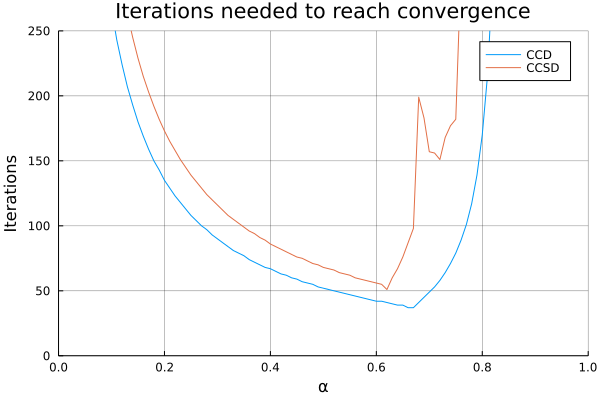

In [23]:
ccd_min = argmin(needed_iters_ccd[2:end])
ccsd_min = argmin(needed_iters_ccsd[2:end])
println("CCD min: α = $(alphas[ccd_min]) iters = $(needed_iters_ccd[ccd_min])")
println("CCSD min: α = $(alphas[ccsd_min]) iters = $(needed_iters_ccsd[ccsd_min])")

plt.plot(yrange = (0, 250), xrange=(0,1), gridalpha=0.5, xlabel="α", ylabel="Iterations", title="Iterations needed to reach convergence")
plt.plot!(alphas[2:end], needed_iters_ccd[2:end], label="CCD")
plt.plot!(alphas[2:end], needed_iters_ccsd[2:end], label="CCSD")
plt.savefig("Figures/alpha_iters.png")
plt.plot!()

## Energy/Iter

In [30]:
ccsd_alpha = setup_CCSD(System(rhf), Alpha(0.61));
ccd_alpha = setup_CCD(System(rhf), Alpha(0.65));
ccsd = setup_CCSD(System(rhf));
ccd = setup_CCD(System(rhf));

iters = 20
ccd_energies = zeros(iters+1)
ccsd_energies = zeros(iters+1)
ccd_alpha_energies = zeros(iters+1)
ccsd_alpha_energies = zeros(iters+1)

ccd_energies[1] = energy(ccd)
ccsd_energies[1] = energy(ccsd)
ccd_alpha_energies[1] = energy(ccd_alpha)
ccsd_alpha_energies[1] = energy(ccsd_alpha)
for i in 2:iters+1
    update!(ccd)
    update!(ccsd)
    update!(ccd_alpha)
    update!(ccsd_alpha)
    ccd_energies[i] = energy(ccd)
    ccsd_energies[i] = energy(ccsd)
    ccd_alpha_energies[i] = energy(ccd_alpha)
    ccsd_alpha_energies[i] = energy(ccsd_alpha)
end

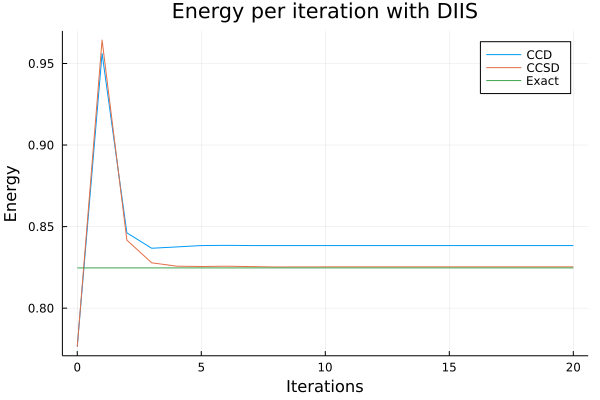

In [35]:
plt.plot(xlabel="Iterations", ylabel="Energy", title="Energy per iteration with DIIS")
plt.plot!(0:iters, ccd_energies, label="CCD")
plt.plot!(0:iters, ccsd_energies, label="CCSD")
plt.plot!([0, 20], [exact, exact], label="Exact")
plt.savefig("Figures/diis_conv.png")
plt.plot!()

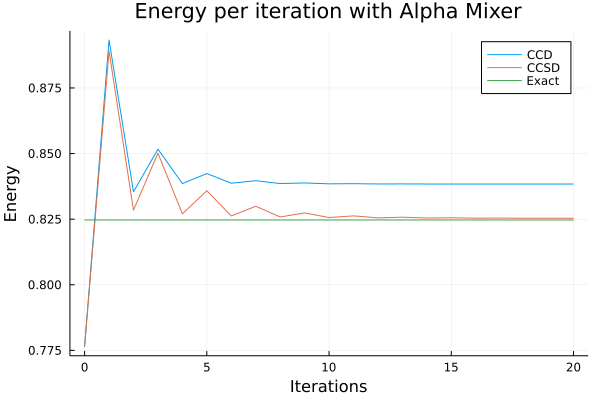

In [34]:
plt.plot(xlabel="Iterations", ylabel="Energy", title="Energy per iteration with Alpha Mixer")
plt.plot!(0:iters, ccd_alpha_energies, label="CCD")
plt.plot!(0:iters, ccsd_alpha_energies, label="CCSD")
plt.plot!([0, 20], [exact, exact], label="Exact")
plt.savefig("Figures/alpha_conv.png")
plt.plot!()